Loading necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import cv2
import h5py
import random
import itertools

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision.utils import save_image

from sklearn.metrics import roc_auc_score, average_precision_score

Check the device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Model parameters

In [5]:
learning_rate = 0.0001
num_epochs = 20
batch_size = 128

## Loading all data

### Loading IXI-T2 dataset

This database consists of images of healthy subjects and is used only to train the model.

In [811]:
data_path = 'IXI-T2'    # path to the dataset
data_files = [f for f in os.listdir(data_path) if f.endswith('.nii.gz')]
all_data = []

# load data for the first 250 subjects
for data_file_id in range(250):
    file_path = os.path.join(data_path, data_files[data_file_id])
    image_nii = nib.load(file_path)
    image_array = image_nii.get_fdata()

    for i in range(image_array.shape[2]):
        slice_image = image_array[:, :, i]
        slice_image = (slice_image - np.min(slice_image)) / (np.max(slice_image) - np.min(slice_image))
        slice_image = cv2.resize(slice_image, (128, 128))
        all_data.append(slice_image)

KeyboardInterrupt: 

Form train and test datasets for training the model and checking the reconstruction performance on the unknown data.

In [ ]:
train_dataset = np.array(all_data)
train_dataset = train_dataset[:, np.newaxis, :, :]
train_dataset = torch.from_numpy(train_dataset).float()

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset_ixi, test_dataset_ixi = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Form dataloaders for training and testing.

In [ ]:
train_loader_ixi = DataLoader(train_dataset_ixi, batch_size=batch_size, shuffle=True)
test_loader_ixi = DataLoader(test_dataset_ixi, batch_size=batch_size, shuffle=True)

### Loading BRATS dataset

This database consists of images of patients with brain tumors and healthy subjects, and is used to train and test the model, depending on the type of the data.

In [6]:
# new line 
directory = 'archive/BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


In [ ]:
data_brats_tumor = {'img': [], 'mask': []}
data_brats_normal = {'img': []}

for file in h5_files:
    file_path = os.path.join(directory, file)
    with h5py.File(file_path, 'r') as file:
        image = file['image'][()]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = cv2.resize(image, (128, 128))
        mask = file['mask'][()]
        mask = cv2.resize(mask, (128, 128))

        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image = image[2, :, :]
        mask = mask[2, :, :]

        if np.max(mask) != 0:
            data_brats_tumor['img'].append(image)
            data_brats_tumor['mask'].append(mask)
        else:
            data_brats_normal['img'].append(image)

In [ ]:
data_brats_tumor['img'] = np.array(data_brats_tumor['img'])
data_brats_tumor['mask'] = np.array(data_brats_tumor['mask'])
data_brats_normal['img'] = np.array(data_brats_normal['img'])

In [ ]:
print(data_brats_tumor['img'].shape), print(data_brats_tumor['mask'].shape), print(data_brats_normal['img'].shape)

(14117, 128, 128)
(14117, 128, 128)
(43078, 128, 128)


(None, None, None)

In [ ]:
data_brats_normal_loader_1 = DataLoader(data_brats_normal['img'][:len(data_brats_normal['img'])//4], batch_size=batch_size, shuffle=True)
data_brats_normal_loader_2 = DataLoader(data_brats_normal['img'][len(data_brats_normal['img'])//4:len(data_brats_normal['img'])//2], batch_size=batch_size, shuffle=True)
data_brats_normal_loader_3 = DataLoader(data_brats_normal['img'][len(data_brats_normal['img'])//2:3*len(data_brats_normal['img'])//4], batch_size=batch_size, shuffle=True)
data_brats_normal_loader_4 = DataLoader(data_brats_normal['img'][3*len(data_brats_normal['img'])//4:], batch_size=batch_size, shuffle=True)

In [ ]:
torch.save(data_brats_normal_loader_1, 'data_brats_normal_loader_1.pth')
torch.save(data_brats_normal_loader_4, 'data_brats_normal_loader_2.pth')
torch.save(data_brats_normal_loader_3, 'data_brats_normal_loader_3.pth')
torch.save(data_brats_normal_loader_4, 'data_brats_normal_loader_4.pth')

In [ ]:
data_brats_tumor_img_loader = DataLoader(data_brats_tumor['img'], batch_size=1, shuffle=True)
data_brats_tumor_mask_loader = DataLoader(data_brats_tumor['mask'], batch_size=1, shuffle=True)

In [ ]:
torch.save(data_brats_tumor_img_loader, 'data_brats_tumor_img_loader.pth')
torch.save(data_brats_tumor_mask_loader, 'data_brats_tumor_mask_loader.pth')

## Loading saved train and test dataloaders

Normal data for training from BRATS dataset

In [7]:
normal_brats = torch.load('brats_final_data/normal.pth')
normal_brats = normal_brats[0, 0, :, :]

In [15]:
train_loader_normal = DataLoader(normal_brats, batch_size=batch_size, shuffle=True)

Tumor data for evaluation from BRATS dataset

In [8]:
bad = torch.load('brats_final_data/bad_images_0.6.pth')
bad = DataLoader(bad, batch_size=1, shuffle=False)
mask_bad = torch.load('brats_final_data/bad_masks_0.6.pth')

Bigger dataset

In [ ]:
bad_new = torch.load('data_brats_tumor_img_loader.pth')
mask_bad_new = torch.load('data_brats_tumor_mask_loader.pth')

In [ ]:
bad_new = bad_new.dataset
bad_new = bad_new[:, np.newaxis, np.newaxis, :, :]
bad_new = torch.from_numpy(bad_new).float()
bad_new = DataLoader(bad_new, batch_size=1, shuffle=False)

In [ ]:
mask_bad_new = mask_bad_new.dataset
mask_bad_new = mask_bad_new.astype(np.float32)

## Variational autoencoder models

### Arhitecture 1

In [17]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 16)  
        self.fc2 = nn.Linear(256 * 4 * 4, 16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)
        mu = self.fc1(x)
        log_var = self.fc2(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(16, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.deconv5 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 256, 4, 4)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decoder(z)
        return x_reconst, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

### Arhitecture 2

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 16, 1, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 8 * 8, 1024)
        self.fc2 = nn.Linear(16 * 8 * 8, 1024)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = self.flatten(x)
        mu = self.fc1(x)
        log_var = self.fc2(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(1024, 16 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(16, 128, 1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 128, 5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 1, 5, stride=2, padding=2, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 16, 8, 8)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decoder(z)
        return x_reconst, mu, log_var

## Gaussian Mixture Variational Autoencoder models

### Arhitecture 1

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, n_components):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)

        self.fc1 = nn.Linear(256*4*4, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim * n_components)
        self.fc_logvar = nn.Linear(hidden_dim, z_dim * n_components)
        self.fc_pi = nn.Linear(hidden_dim, n_components)
        self.n_components = n_components
        self.z_dim = z_dim

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)

        h = F.relu(self.fc1(x))
        pi = F.softmax(self.fc_pi(h), dim=1)
        
        mu = self.fc_mu(h).view(-1, self.n_components, self.z_dim)
        logvar = self.fc_logvar(h).view(-1, self.n_components, self.z_dim)
        return pi, mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(16, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.deconv5 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        
        self.fc2 = nn.Linear(z_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = x.view(x.size(0), 256, 4, 4)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))
        return x

class GMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, n_components):
        super(GMVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim, n_components)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)
        self.n_components = n_components
        self.z_dim = z_dim

    def reparameterize(self, pi, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std  # (batch_size, n_components, z_dim)
        z = z.view(-1, self.n_components, self.z_dim)  # Reshape for GMM
        z = torch.sum(pi.unsqueeze(-1) * z, dim=1)  # Weighted sum
        return z

    def forward(self, x):
        pi, mu, logvar = self.encoder(x)
        z = self.reparameterize(pi, mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, pi, mu, logvar

    def loss_function(self, x, x_recon, pi, mu, logvar):
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        log_pi = torch.log(pi + 1e-10)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)
        kl_div = torch.sum(pi * kl_div + pi * log_pi, dim=1).mean()
        return recon_loss + kl_div

### Arhitecture 2

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, n_components):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 16, 1, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(16)
        self.flatten = nn.Flatten()
    
        self.fc1 = nn.Linear(16 * 8 * 8, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim * n_components)
        self.fc_logvar = nn.Linear(hidden_dim, z_dim * n_components)
        self.fc_pi = nn.Linear(hidden_dim, n_components)
        self.n_components = n_components
        self.z_dim = z_dim

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)

        h = F.relu(self.fc1(x))
        pi = F.softmax(self.fc_pi(h), dim=1)
        
        mu = self.fc_mu(h).view(-1, self.n_components, self.z_dim)
        logvar = self.fc_logvar(h).view(-1, self.n_components, self.z_dim)
        return pi, mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(16, 16 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(16, 128, 1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 128, 5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 1, 5, stride=2, padding=2, output_padding=1)
        
        self.fc2 = nn.Linear(z_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = x.view(x.size(0), 16, 8, 8)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))
        return x

class GMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, n_components):
        super(GMVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim, n_components)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)
        self.n_components = n_components
        self.z_dim = z_dim

    def reparameterize(self, pi, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std  # (batch_size, n_components, z_dim)
        z = z.view(-1, self.n_components, self.z_dim)  # Reshape for GMM
        z = torch.sum(pi.unsqueeze(-1) * z, dim=1)  # Weighted sum
        return z

    def forward(self, x):
        pi, mu, logvar = self.encoder(x)
        z = self.reparameterize(pi, mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, pi, mu, logvar

    def loss_function(self, x, x_recon, pi, mu, logvar):
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        log_pi = torch.log(pi + 1e-10)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)
        kl_div = torch.sum(pi * kl_div + pi * log_pi, dim=1).mean()
        return recon_loss + kl_div

## Training and testing the model

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

#### VAE

In [11]:
def train_vae(epoch, model, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img = data

        img = Variable(img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)

In [12]:
def test_vae(model, test_loader, test_loader_mask, tresh = 0.1, dim_kernel = 3, iter_morph = 2, name_img = 'name', lista_img = [11,253,877,25,600]):
    auc_all, dice_coef_all, auprc_all = [], [], []
    test_loss = 0

    comparison_all = torch.Tensor()

    model.eval()

    img_all = []
    recon_batch_all = []
    mask1_all = []
    img_diff_all = []

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            img = data[np.newaxis, :, :]
            img = Variable(img)[0, 0, :, :]

            # reconstruction
            recon_batch, mu, log_var = model(img)

            # difference between original and reconstructed image
            img_diff = torch.abs((recon_batch - img)**2)

            # normalize
            img_diff = img_diff - torch.min(img_diff)
            img_diff = img_diff / torch.max(img_diff)

            # binarize
            img_diff[img_diff < tresh], img_diff[img_diff >= tresh] = 0, 1
            
            #dilate and erode
            img_diff = img_diff.view(128, 128).cpu().numpy()
            img_diff = cv2.dilate(img_diff, np.ones((dim_kernel, dim_kernel), np.uint8), iterations=iter_morph)
            img_diff = cv2.erode(img_diff, np.ones((dim_kernel, dim_kernel), np.uint8), iterations=iter_morph)
            img_diff = torch.from_numpy(img_diff).float()
            img_diff = img_diff[np.newaxis, np.newaxis, :, :]

            # leave only the biggest object
            img_diff = img_diff.view(128, 128).cpu().numpy()
            img_diff = img_diff[np.newaxis, np.newaxis, :, :]
            n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_diff[0, 0].astype(np.uint8))
            if np.sum(stats[1:, cv2.CC_STAT_AREA]) != 0:
                largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                img_diff[0][0] = (labels == largest_label).astype(np.float32)
            img_diff = torch.from_numpy(img_diff).float()

            test_loss += loss_function(recon_batch, img, mu, log_var).item()

            mask = np.array(test_loader_mask[i])[np.newaxis, :, :]
            mask = torch.from_numpy(mask).float()
            mask = mask.view(128, 128).cpu().numpy()

            n = min(img.size(0), 8)

            img_diff_flatten = img_diff.view(128, 128).cpu().numpy().flatten()

            masks_tog = img_diff.view(128, 128).cpu().numpy()*0.7 + mask*0.3
            masks_tog = torch.from_numpy(masks_tog).float()
            masks_tog = masks_tog[np.newaxis, :, :]

            mask1 = torch.from_numpy(mask).float()
            mask1 = mask1[np.newaxis, np.newaxis, :, :]

            dc = dice_coef(mask.flatten(), img_diff_flatten)
            ap = average_precision_score(mask.flatten(), img_diff_flatten)
            roc = roc_auc_score(mask.flatten(), img_diff_flatten)

            dice_coef_all.append(dc)
            auprc_all.append(ap)
            auc_all.append(roc)

            masks_tog = masks_tog.view(1, 1, 128, 128)
            #comparison = torch.cat([img[:n], recon_batch.view(1, 1, 128, 128)[:n], img_diff[:n], mask1[:n]])
            #comparison_all = torch.cat([comparison_all, comparison], dim=3)

            if i in lista_img:
                img_all.append(img)
                recon_batch_all.append(recon_batch)
                mask1_all.append(mask1)
                img_diff_all.append(img_diff)

    #save_image(comparison_all.cpu(), 'res/' + name_img + '.png', nrow=n)      
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    print('====> AUC: {:.4f}'.format(np.mean(auc_all)))
    print('====> AUPRC: {:.4f}'.format(np.mean(auprc_all)))
    print('====> Dice coef: {:.4f}'.format(np.mean(dice_coef_all)))

    plt.figure(figsize=(15, 15))
    for i in range(4):
        plt.subplot(5, 4, i*4 + 1)
        plt.imshow(img_all[i].view(128, 128).cpu().numpy(), cmap='gray')
        if i == 0:
            plt.title('Originalne slike')
        plt.axis('off')

        plt.subplot(5, 4, i*4 + 2)
        plt.imshow(recon_batch_all[i].view(128, 128).cpu().numpy(), cmap='gray')
        if i == 0:
            plt.title('Rekonstruisane slike')
        plt.axis('off')

        plt.subplot(5, 4, i*4 + 3)
        plt.imshow(mask1_all[i].view(128, 128).cpu().numpy(), cmap='gray')
        if i == 0:
            plt.title('Originalne maske')
        plt.axis('off')

        plt.subplot(5, 4, i*4 + 4)
        plt.imshow(img_diff_all[i].view(128, 128).cpu().numpy(), cmap='gray')
        if i == 0:
            plt.title('Dobijene maske')
        plt.axis('off')
    
    plt.show()
    
    return test_loss, auc_all, auprc_all, dice_coef_all

#### GMVAE

In [25]:
def train_gmvae(epoch, model, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img = data
        img = Variable(img)
        optimizer.zero_grad()
        recon_batch, pi, mu, log_var = model(img)
        loss = model.loss_function(img, recon_batch, pi, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)

In [45]:
def test_gmvae(model, test_loader, test_loader_mask, tresh = 0.1, dim_kernel = 3, iter_morph = 2, name_img = 'name', plot_pic = False):
    all_auc, all_dice, all_auprc = [], [], []
    test_loss = 0

    comparison_all = torch.Tensor()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            img = data[0]
            img = Variable(img)

            # reconstruction
            recon_batch, pi, mu, log_var = model(img)

            # difference between original and reconstructed image
            img_diff = torch.abs((recon_batch - img)**2)

            # normalize
            img_diff = img_diff - torch.min(img_diff)
            img_diff = img_diff / torch.max(img_diff)

            # binarize
            img_diff[img_diff < tresh], img_diff[img_diff >= tresh] = 0, 1
            
            #dilate and erode
            img_diff = img_diff.view(128, 128).cpu().numpy()
            img_diff = cv2.dilate(img_diff, np.ones((dim_kernel, dim_kernel), np.uint8), iterations=iter_morph)
            img_diff = cv2.erode(img_diff, np.ones((dim_kernel, dim_kernel), np.uint8), iterations=iter_morph)
            img_diff = torch.from_numpy(img_diff).float()
            img_diff = img_diff[np.newaxis, np.newaxis, :, :]

            # leave only the biggest object
            img_diff = img_diff.view(128, 128).cpu().numpy()
            img_diff = img_diff[np.newaxis, np.newaxis, :, :]
            n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_diff[0, 0].astype(np.uint8))
            if np.sum(stats[1:, cv2.CC_STAT_AREA]) != 0:
                largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                img_diff[0][0] = (labels == largest_label).astype(np.float32)
            img_diff = torch.from_numpy(img_diff).float()

            test_loss += model.loss_function(img, recon_batch, pi, mu, log_var).item()

            mask = test_loader_mask[i]
            
            dc = dice_coef(mask.flatten(), img_diff.view(128, 128).cpu().numpy().flatten())
            ap = average_precision_score(mask.flatten(), img_diff.view(128, 128).cpu().numpy().flatten())
            roc = roc_auc_score(mask.flatten(), img_diff.view(128, 128).cpu().numpy().flatten())

            all_dice.append(dc)
            all_auc.append(roc)
            all_auprc.append(ap)

            if plot_pic and i>900:
                plt.figure(figsize=(10,5))
                plt.subplot(1, 4, 1)
                plt.imshow(img.view(128, 128).cpu().numpy(), cmap='gray')
                plt.subplot(1, 4, 2)
                plt.imshow(recon_batch.view(128, 128).cpu().numpy(), cmap='gray')
                plt.subplot(1, 4, 3)
                plt.imshow(img_diff.view(128, 128).cpu().numpy(), cmap='gray')
                plt.subplot(1, 4, 4)
                plt.imshow(mask, cmap='gray')
                plt.show()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print(f'Test loss: {test_loss}')
    print(f'Dice coef: {np.mean(all_dice)}')
    print(f'AUC: {np.mean(all_auc)}')
    print(f'AUPRC: {np.mean(all_auprc)}')

    return test_loss, all_auc, all_auprc, all_dice

### Evaluation 

#### VAE

In [19]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_loss = []
for epoch in range(20):
    total_loss.append(train_vae(epoch, model, train_loader_normal))

In [ ]:
torch.save(model.state_dict(), 'models/vae2.pth')

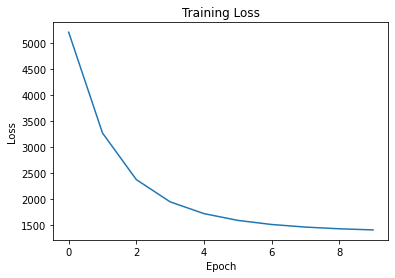

In [ ]:
plt.figure()
plt.plot(total_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

vae1 - dobre - 11,27,530,len(mask_bad)-4
     - lose - 100,600,820,1100
vae1 100 - dobre - 2,48,750,930
         - lose - 0,400,710,1000
vae2 - dobre - 50,80,500,900
     - lose
gmvae1 - dobre 
       - lose
gmvae2 - dobre
       - lose
         50,80,500

====> Test set loss: 2889.0718
====> AUC: 0.7229
====> AUPRC: 0.2840
====> Dice coef: 0.4665


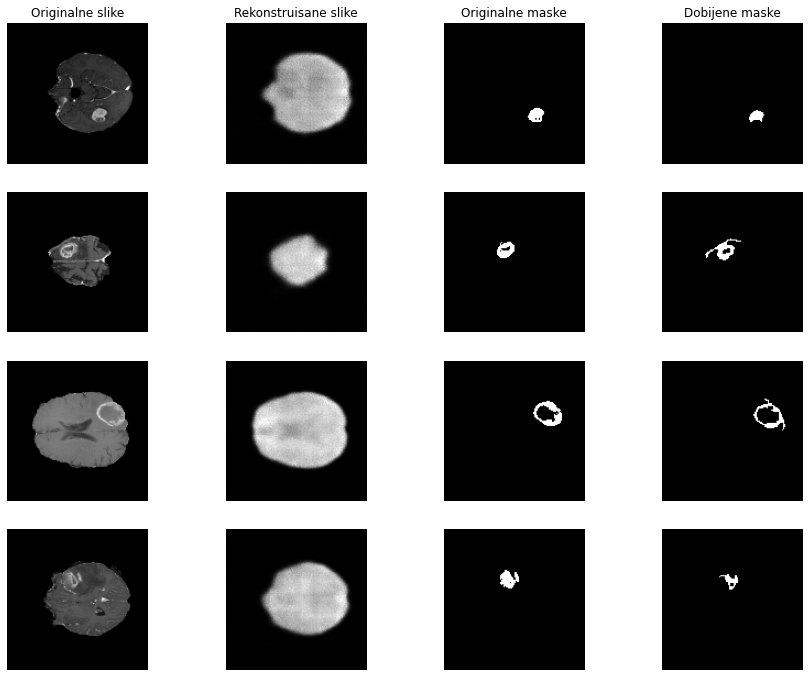

In [ ]:
img_name = 'vae1.1.1.aug'
test_loss, auc_all, auprc_all, dice_coef_all = test_vae(model, bad, mask_bad, tresh = 0.1, dim_kernel = 2, iter_morph = 2, name_img = img_name, lista_img=[50,80,500,899])

In [22]:
image_vae2 = cv2.imread('res/gmvae1.png')

In [23]:
k = 158980//(len(bad))

In [24]:
i= 3
img = image_vae2[:, k*i:(i+1)*k, :]

nn = 7
plt.figure(figsize=(nn, nn))
plt.imshow(img)
plt.axis('off')
plt.show()

TypeError: 'NoneType' object is not subscriptable

#### GMVAE

In [30]:
num_epochs = 10

In [31]:
input_channels = 1
intermediate_channels = 16
dim_w = 16
dim_z = 16
n_components = 10
output_dim = 128 * 128

model = GMVAE(input_dim=output_dim, hidden_dim=intermediate_channels, z_dim=dim_z, n_components=n_components)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
model.load_state_dict(torch.load('models/gmvae1.pth'))

<All keys matched successfully>

In [545]:
losses = []
for epoch in range(num_epochs):
    losses.append(train_gmvae(epoch, model, train_loader_normal))

Train Epoch: 0 [0/20998 (0%)]	Loss: 13153.560547
Train Epoch: 0 [12800/20998 (61%)]	Loss: 4346.300781
====> Epoch: 0 Average loss: 5679.0033
Train Epoch: 1 [0/20998 (0%)]	Loss: 2986.147461
Train Epoch: 1 [12800/20998 (61%)]	Loss: 2033.144653
====> Epoch: 1 Average loss: 2269.1169
Train Epoch: 2 [0/20998 (0%)]	Loss: 1840.710693
Train Epoch: 2 [12800/20998 (61%)]	Loss: 1492.171265
====> Epoch: 2 Average loss: 1698.8942
Train Epoch: 3 [0/20998 (0%)]	Loss: 1518.550903
Train Epoch: 3 [12800/20998 (61%)]	Loss: 1398.389648
====> Epoch: 3 Average loss: 1535.3904
Train Epoch: 4 [0/20998 (0%)]	Loss: 1375.807129
Train Epoch: 4 [12800/20998 (61%)]	Loss: 1373.671753
====> Epoch: 4 Average loss: 1468.8195
Train Epoch: 5 [0/20998 (0%)]	Loss: 1223.553467
Train Epoch: 5 [12800/20998 (61%)]	Loss: 1526.161621
====> Epoch: 5 Average loss: 1434.8165
Train Epoch: 6 [0/20998 (0%)]	Loss: 1399.147461
Train Epoch: 6 [12800/20998 (61%)]	Loss: 1404.310913
====> Epoch: 6 Average loss: 1416.9609
Train Epoch: 7 [0/2

In [547]:
torch.save(model.state_dict(), 'models/gmvae1.pth')

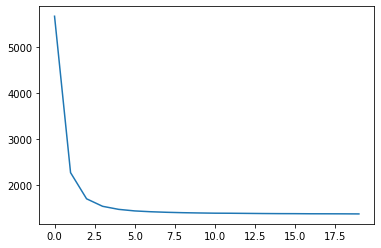

In [546]:
plt.plot(losses)

In [ ]:
img_name = 'gmvae1'
test_loss, auc_all, auprc_all, dice_coef_all = test_gmvae(model, bad, mask_bad, tresh = 0.1, dim_kernel = 3, iter_morph = 2, name_img = img_name, plot_pic = True)